# Bayesian Regression - Introduction

Regression is one of the most common and basic supervised learning tasks in machine learning. Suppose we’re given a dataset $D$ of the form

$D = {(Xi, yi)} for i = 1,2,...,N$

The goal of linear regression is to fit a function to the data of the form:

$y=wX + b + e$

where $w$ and $b$ are learnable parameters and $e$ represents observation noise. Specifically $w$ is a matrix of weights and $b$ is a bias vector.

In this tutorial, we will first implement linear regression in PyTorch and learn point estimates for the parameters $w$ and $b$. Then we will see how to incorporate uncertainty into our estimates by using Pyro to implement Bayesian regression. Additionally, we will learn how to use the Pyro’s utility functions to do predictions and serve our model using TorchScript.

## Setup

In [1]:
import os
from functools import partial
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist

# for CI testing
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.4')
pyro.set_rng_seed(1)

# set matplotlib settings
%matplotlib inline
plt.style.use('default')

/Users/sina/Library/Mobile Documents/com~apple~CloudDocs/Git_Projects/Deep-probabilistic-modeling/PyroVenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset
We would like to explore the relationship between topographic heterogeneity of a nation as measured by the Terrain Ruggedness Index (variable rugged in the dataset) and its GDP per capita. In particular, it should be noted that terrain ruggedness or bad geography is related to poorer economic performance outside of Africa, but rugged terrains have had a reverse effect on income for African nations. Let us look at the data and investigate this relationship. We will be focusing on three features from the dataset:

* rugged: quantifies the Terrain Ruggedness Index
* cont_africa: whether the given nation is in Africa
* rgdppc_2000: Real GDP per capita for the year 2000

The response variable GDP is highly skewed, so we will log-transform it.

In [2]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

[Text(0.5, 0, 'Terrain Ruggedness Index'),
 Text(0, 0.5, 'log GDP (2000)'),
 Text(0.5, 1.0, 'African Nations')]

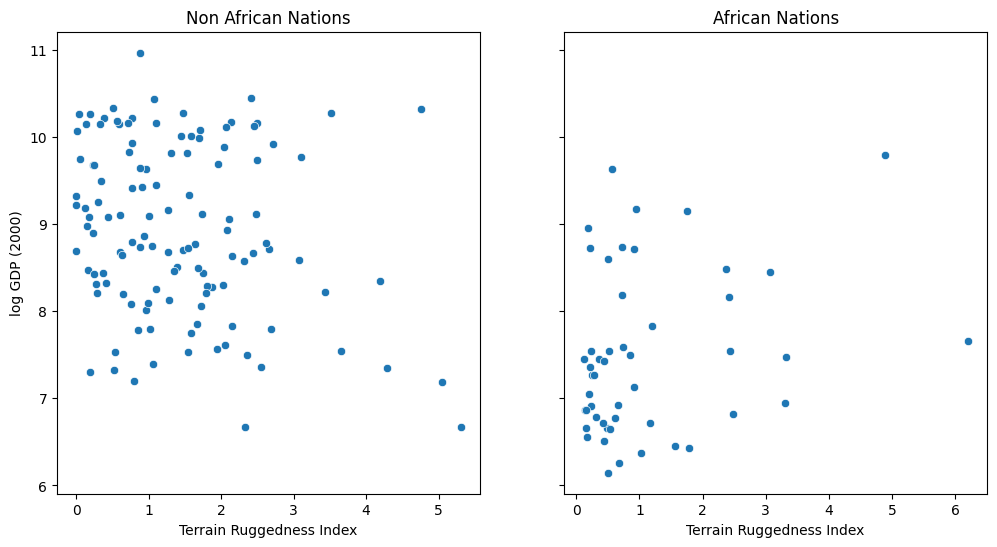

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]

sns.scatterplot(x=non_african_nations["rugged"],
                y=non_african_nations["rgdppc_2000"],
                ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")

sns.scatterplot(x=african_nations["rugged"],
                y=african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations")

## Linear Regression

We would like to predict log GDP per capita of a nation as a function of two features from the dataset - whether the nation is in Africa, and its Terrain Ruggedness Index. We will create a trivial class called PyroModule[nn.Linear] that subclasses PyroModule and torch.nn.Linear. PyroModule is very similar to PyTorch’s nn.Module, but additionally supports Pyro primitives as attributes that can be modified by Pyro’s effect handlers (see the next section on how we can have module attributes that are pyro.sample primitives). Some general notes:

* Learnable parameters in PyTorch modules are instances of nn.Parameter, in this case the weight and bias parameters of the nn.Linear class. When declared inside a PyroModule as attributes, these are automatically registered in Pyro’s param store. While this model does not require us to constrain the value of these parameters during optimization, this can also be easily achieved in PyroModule using the PyroParam statement.
* Note that while the forward method of PyroModule[nn.Linear] inherits from nn.Linear, it can also be easily overridden. e.g. in the case of logistic regression, we apply a sigmoid transformation to the linear predictor.

In [4]:
from torch import nn
from pyro.nn import PyroModule

assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)

## Training with PyTorch Optimizers

Note that in addition to the two features rugged and cont_africa, we also include an interaction term in our model, which lets us separately model the effect of ruggedness on the GDP for nations within and outside Africa.

We use the mean squared error (MSE) as our loss and Adam as our optimizer from the torch.optim module. We would like to optimize the parameters of our model, namely the weight and bias parameters of the network, which corresponds to our regression coefficents and the intercept.

In [5]:
# Dataset: add a feature to capture the interaction between "cont_africa" and "rugged"
df["cont_africa_x_rugged"] = df["cont_africa"] * df["rugged"]
data = torch.tensor(df[["cont_africa", "rugged", "cont_africa_x_rugged", "rgdppc_2000"]].values,
                     dtype=torch.float)
x_data, y_data = data[:, :-1], data[:, -1]

# Regression model
linear_reg_model = PyroModule[nn.Linear](3, 1)

# Define loss and optimize
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(linear_reg_model.parameters(), lr=0.05)
num_iteration = 1500 if not smoke_test else 2

def train():
    # run the model forward on the data
    y_pred = linear_reg_model(x_data).squeeze(-1)
    # calculate the mse loss
    loss = loss_fn(y_pred, y_data)
    # initialize graidents to zero
    optim.zero_grad()
    # backpropagate
    loss.backward()
    # take a gradient step
    optim.step()
    return loss

for j in range(num_iteration):
    loss = train()
    if (j + 1) % 50 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))

# incpect learned parameters
print("learned paramaters:")
for name, param in linear_reg_model.named_parameters():
    print(name, param.data.numpy())

[iteration 0050] loss: 3179.7852
[iteration 0100] loss: 1616.1371
[iteration 0150] loss: 1109.4116
[iteration 0200] loss: 833.7546
[iteration 0250] loss: 637.5823
[iteration 0300] loss: 488.2653
[iteration 0350] loss: 376.4651
[iteration 0400] loss: 296.0484
[iteration 0450] loss: 240.6140
[iteration 0500] loss: 203.9386
[iteration 0550] loss: 180.6171
[iteration 0600] loss: 166.3494
[iteration 0650] loss: 157.9457
[iteration 0700] loss: 153.1786
[iteration 0750] loss: 150.5735
[iteration 0800] loss: 149.2020
[iteration 0850] loss: 148.5065
[iteration 0900] loss: 148.1668
[iteration 0950] loss: 148.0070
[iteration 1000] loss: 147.9347
[iteration 1050] loss: 147.9032
[iteration 1100] loss: 147.8900
[iteration 1150] loss: 147.8847
[iteration 1200] loss: 147.8827
[iteration 1250] loss: 147.8819
[iteration 1300] loss: 147.8817
[iteration 1350] loss: 147.8815
[iteration 1400] loss: 147.8815
[iteration 1450] loss: 147.8815
[iteration 1500] loss: 147.8815
learned paramaters:
weight [[-1.94785

### Plotting the Regression Fit

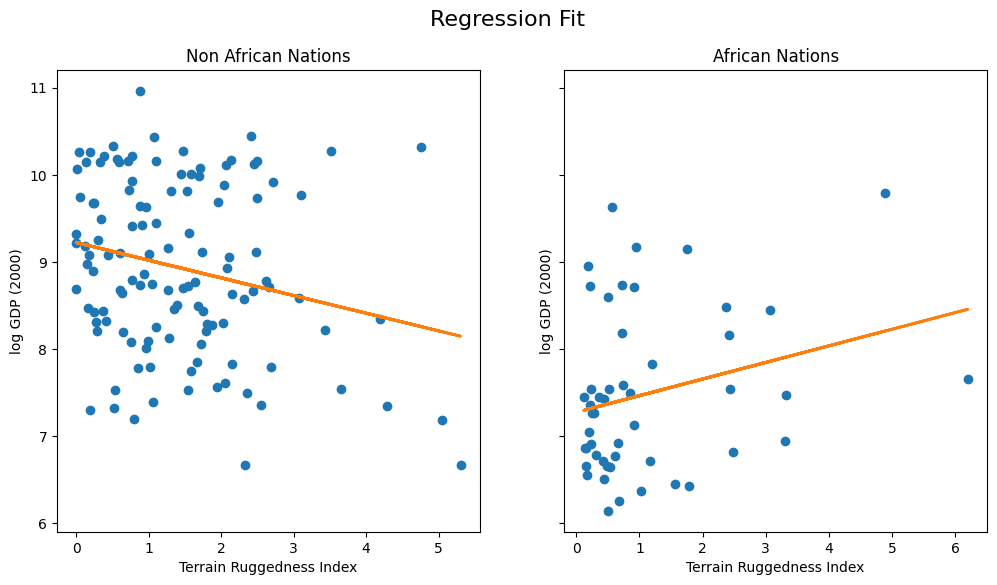

In [6]:
fit = df.copy()
fit["mean"] = linear_reg_model(x_data).detach().cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = fit[fit["cont_africa"] == 1]
non_african_nations = fit[fit["cont_africa"] == 0]
fig.suptitle("Regression Fit", fontsize=16)
ax[0].plot(non_african_nations["rugged"], non_african_nations["rgdppc_2000"], "o")
ax[0].plot(non_african_nations["rugged"], non_african_nations["mean"], linewidth=2)
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")

ax[1].plot(african_nations["rugged"], african_nations["rgdppc_2000"], "o")
ax[1].plot(african_nations["rugged"], african_nations["mean"], linewidth=2)
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title = "African Nations");

We notice that the relationship between terrain ruggedness has an inverse relationship with GDP for non-African nations, but it positively affects the GDP for African nations. It is however unclear how robust this trend is. In particular, we would like to understand how the regression fit would vary due to parameter uncertainty. To address this, we will build a simple Bayesian model for linear regression. Bayesian modeling offers a systematic framework for reasoning about model uncertainty. Instead of just learning point estimates, we’re going to learn a distribution over parameters that are consistent with the observed data.

# Bayesian Regression with Pyro’s Stochastic Variational Inference (SVI)
### Model

In order to make our linear regression Bayesian, we need to put priors on the parameters $w$ and $b$. These are distributions that represent our prior belief about reasonable values for $w$ and $b$ (before observing any data).

Making a Bayesian model for linear regression is very intuitive using PyroModule as earlier. Note the following:

* The BayesianRegression module internally uses the same PyroModule[nn.Linear] module. However, note that we replace the weight and the bias of the this module with PyroSample statements. These statements allow us to place a prior over the weight and bias parameters, instead of treating them as fixed learnable parameters. For the bias component, we set a reasonably wide prior since it is likely to be substantially above 0.

* The BayesianRegression.forward method specifies the generative process. We generate the mean value of the response by calling the linear module (which, as you saw, samples the weight and bias parameters from the prior and returns a value for the mean response). Finally we use the obs argument to the pyro.sample statement to condition on the observed data y_data with a learned observation noise sigma. The model returns the regression line given by the variable mean.

In [7]:
from pyro.nn import PyroSample

class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

## Using an AutoGuide

In order to do inference, i.e. learn the posterior distribution over our unobserved parameters, we will use Stochastic Variational Inference (SVI). The guide determines a family of distributions, and SVI aims to find an approximate posterior distribution from this family that has the lowest KL divergence from the true posterior.

Users can write arbitrarily flexible custom guides in Pyro, but in this tutorial, we will restrict ourselves to Pyro’s autoguide library. In the next tutorial, we will explore how to write guides by hand.

To begin with, we will use the AutoDiagonalNormal guide that models the distribution of unobserved parameters in the model as a Gaussian with diagonal covariance, i.e. it assumes that there is no correlation amongst the latent variables (quite a strong modeling assumption as we shall see in Part II). Under the hood, this defines a guide that uses a Normal distribution with learnable parameters corresponding to each sample statement in the model. e.g. in our case, this distribution should have a size of (5,) correspoding to the 3 regression coefficients for each of the terms, and 1 component contributed each by the intercept term and sigma in the model.

Autoguide also supports learning MAP estimates with AutoDelta or composing guides with AutoGuideList (see the docs for more information).

In [8]:
from pyro.infer.autoguide import AutoDiagonalNormal

model = BayesianRegression(3, 1)
guide = AutoDiagonalNormal(model)

## Optimizing the Evidence Lower Bound

We will use stochastic variational inference (SVI) for doing inference. Just like in the non-Bayesian linear regression model, each iteration of our training loop will take a gradient step, with the difference that in this case, we’ll use the Evidence Lower Bound (ELBO) objective instead of the MSE loss by constructing a Trace_ELBO object that we pass to SVI.

In [9]:
from pyro.infer import SVI, Trace_ELBO

adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

Note that we use the Adam optimizer from Pyro’s optim module and not the torch.optim module as earlier. Here Adam is a thin wrapper around torch.optim.Adam (see here for a discussion). Optimizers in pyro.optim are used to optimize and update parameter values in Pyro’s parameter store. In particular, you will notice that we do not need to pass in learnable parameters to the optimizer since that is determined by the guide code and happens behind the scenes within the SVI class automatically. To take an ELBO gradient step we simply call the step method of SVI. The data argument we pass to SVI.step will be passed to both model() and guide(). The complete training loop is as follows:

In [10]:
pyro.clear_param_store()
for j in range(num_iteration):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

[iteration 0001] loss: 6.2310
[iteration 0101] loss: 3.5269
[iteration 0201] loss: 3.2377
[iteration 0301] loss: 3.0867
[iteration 0401] loss: 2.6374
[iteration 0501] loss: 2.0617
[iteration 0601] loss: 1.4856
[iteration 0701] loss: 1.4631
[iteration 0801] loss: 1.4632
[iteration 0901] loss: 1.4592
[iteration 1001] loss: 1.4939
[iteration 1101] loss: 1.4989
[iteration 1201] loss: 1.4937
[iteration 1301] loss: 1.4679
[iteration 1401] loss: 1.4581


In [11]:
guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([-2.2371, -1.8097, -0.1691,  0.3790,  9.1824])
AutoDiagonalNormal.scale tensor([0.0552, 0.1143, 0.0387, 0.0769, 0.0700])


As you can see, instead of just point estimates, we now have uncertainty estimates (AutoDiagonalNormal.scale) for our learned parameters. Note that Autoguide packs the latent variables into a single tensor, in this case, one entry per variable sampled in our model. Both the loc and scale parameters have size (5,), one for each of the latent variables in the model, as we had remarked earlier.

To look at the distribution of the latent parameters more clearly, we can make use of the AutoDiagonalNormal.quantiles method which will unpack the latent samples from the autoguide, and automatically constrain them to the site’s support (e.g. the variable sigma must lie in (0, 10)). We see that the median values for the parameters are quite close to the Maximum Likelihood point estimates we obtained from our first model.

In [12]:
guide.quantiles([0.25, 0.5, 0.75])

{'sigma': tensor([0.9327, 0.9647, 0.9976]),
 'linear.weight': tensor([[[-1.8868, -0.1952,  0.3272]],
 
         [[-1.8097, -0.1691,  0.3790]],
 
         [[-1.7325, -0.1430,  0.4309]]]),
 'linear.bias': tensor([[9.1351],
         [9.1824],
         [9.2296]])}

# Model Evaluation

To evaluate our model, we’ll generate some predictive samples and look at the posteriors. For this we will make use of the Predictive utility class.

* We generate 800 samples from our trained model. Internally, this is done by first generating samples for the unobserved sites in the guide, and then running the model forward by conditioning the sites to values sampled from the guide. Refer to the Model Serving section for insight on how the Predictive class works.

* Note that in return_sites, we specify both the outcome ("obs" site) as well as the return value of the model ("_RETURN") which captures the regression line. Additionally, we would also like to capture the regression coefficients (given by "linear.weight") for further analysis.

* The remaining code is simply used to plot the 90% CI for the two variables from our model.

In [13]:
from pyro.infer import Predictive

def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v,0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

predictive = Predictive(model, guide=guide, num_samples=800,
                        return_sites=("linear.weight", "obs", "_RETURN"))
samples = predictive(x_data)
pred_summary = summary(samples)

In [14]:
mu = pred_summary["_RETURN"]
y = pred_summary["obs"]
predictions = pd.DataFrame({
    "cont_africa": x_data[:, 0],
    "rugged": x_data[:, 1],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_gdp": y_data,
})

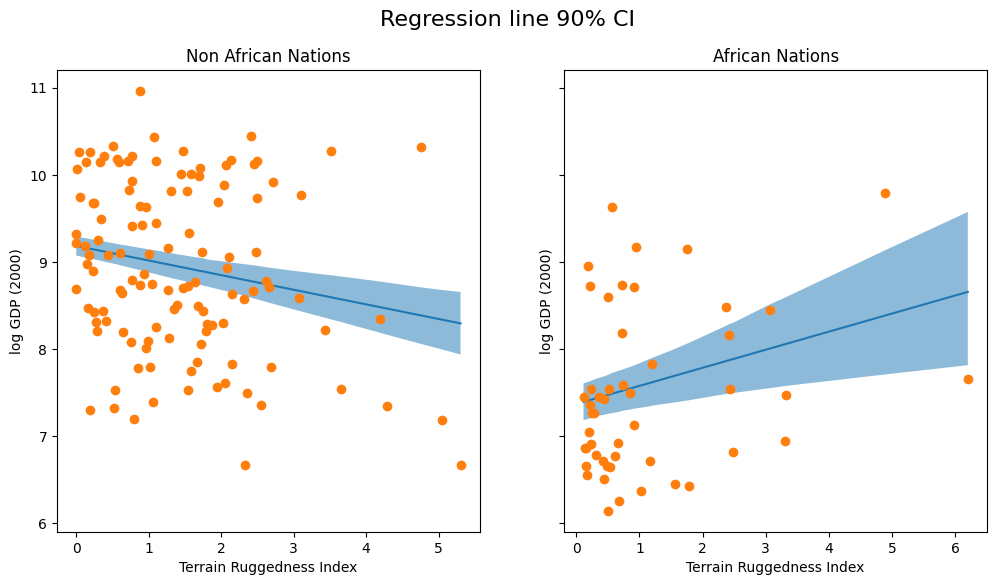

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = predictions[predictions["cont_africa"] == 1]
non_african_nations = predictions[predictions["cont_africa"] == 0]
african_nations = african_nations.sort_values(by=["rugged"])
non_african_nations = non_african_nations.sort_values(by=["rugged"])
fig.suptitle("Regression line 90% CI", fontsize=16)

ax[0].plot(non_african_nations["rugged"],
           non_african_nations["mu_mean"])
ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["mu_perc_5"],
                   non_african_nations["mu_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])
ax[1].plot(african_nations["rugged"],
           african_nations["mu_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["mu_perc_5"],
                   african_nations["mu_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");


The above figure shows the uncertainty in our estimate of the regression line, and the 90% CI around the mean. We can also see that most of the data points actually lie outside the 90% CI, and this is expected because we have not plotted the outcome variable which will be affected by sigma! Let us do so next.

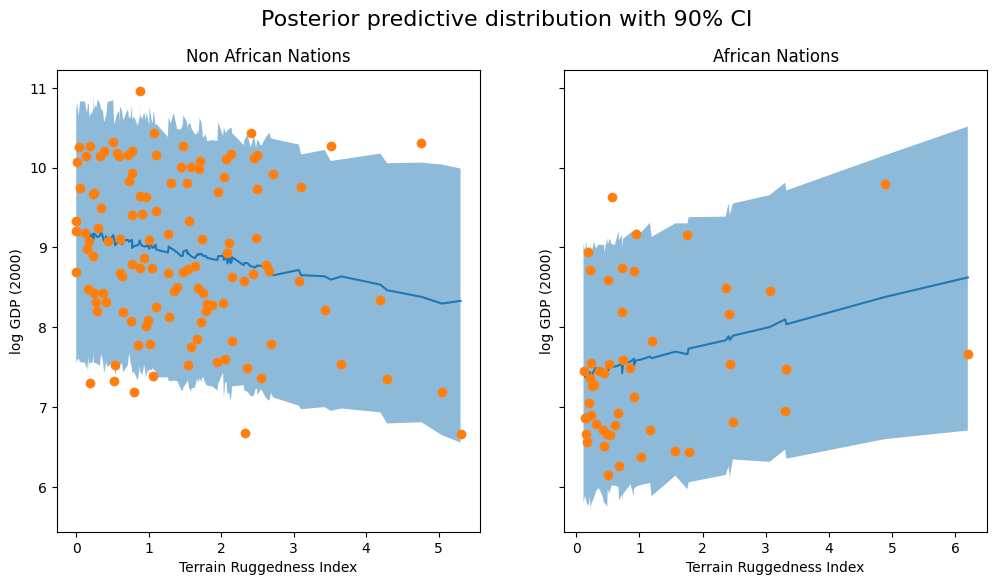

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["y_perc_5"],
                   non_african_nations["y_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])

ax[1].plot(african_nations["rugged"],
           african_nations["y_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["y_perc_5"],
                   african_nations["y_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

We observe that the outcome from our model and the 90% CI accounts for the majority of the data points that we observe in practice. It is usually a good idea to do such posterior predictive checks to see if our model gives valid predictions.

Finally, let us revisit our earlier question of how robust the relationship between terrain ruggedness and GDP is against any uncertainty in the parameter estimates from our model. For this, we plot the distribution of the slope of the log GDP given terrain ruggedness for nations within and outside Africa.

/var/folders/6q/mv1t578n5dd41214yd5lkclh0000gn/T/ipykernel_3261/107852488.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(gamma_within_africa, kde_kws={"label": "African nations"},)
/var/folders/6q/mv1t578n5dd41214yd5lkclh0000gn/T/ipykernel_3261/107852488.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


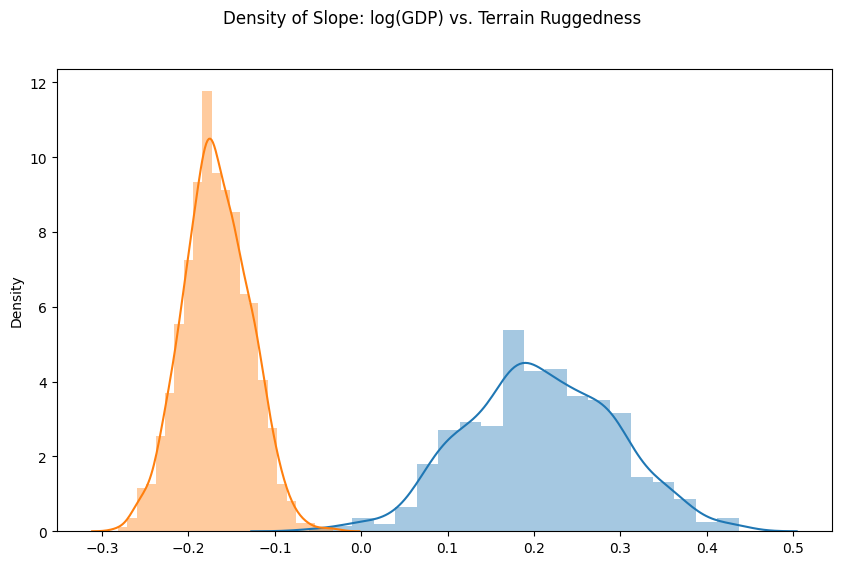

In [22]:
weight = samples["linear.weight"]
weight = weight.reshape(weight.shape[0], 3)
gamma_within_africa = weight[:, 1] + weight[:, 2]
gamma_outside_africa = weight[:, 1]

fig = plt.figure(figsize=(10, 6))
sns.distplot(gamma_within_africa, kde_kws={"label": "African nations"},)
sns.distplot(gamma_outside_africa, kde_kws={"label": "Non-african nations"})
fig.suptitle("Density of Slope: log(GDP) vs. Terrain Ruggedness");

As can be seen above, the probability mass for African nations is largely concentrated in the positive region and vice-versa for other nations, lending further credence to the original hypothesis.